# Basic Bayesian GMM with MCMC (via PyMC)

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
from sklearn import mixture

import re
import numpy as np

Couldn't import dot_parser, loading of dot files will not be possible.


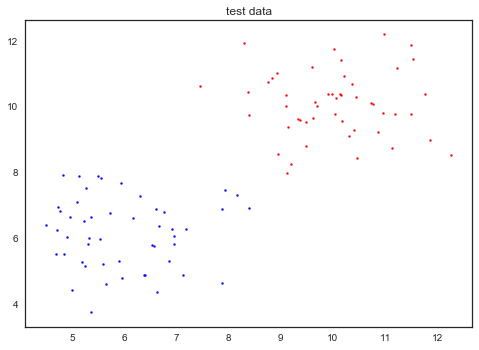

In [3]:
#-------------   data parameters
K = 2 #number of components
N = 100 #number of observations
M = 2 #number of attributes per observation

n_samples = int(N/2.0) #number of points in each component
mu1 = np.array([10, 10]) #mean of component 1
mu2 = np.array([6, 6]) #mean of component 1

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on mu1
comp1 = np.random.randn(n_samples, M) + mu1

# generate spherical data centered on mu2
comp2 = np.random.randn(N - n_samples, M) + mu2

# concatenate the two datasets into training set
data = np.vstack([comp1, comp2])

#plot the components
plt.scatter(comp1[:, 0], comp1[:, 1], 4, color='r')
plt.scatter(comp2[:, 0], comp2[:, 1], 4, color='b')

plt.title('test data')
plt.axis('tight')
plt.show()

In [4]:
#Sampling parameters
iters =10000
burnin = 0.4

#-------------
#----------------------------- the model
#-------------

#-------------   model parameters
alpha = np.array( [0.5] * K ) #shape parameter 
nu = M + 1 #degrees of freedom (greater than K - 1)
W = np.eye(M) #scale matrix (positive)
beta = 1. #scale for wishart-normal dist
eta = np.array( [0] * M ) #mean for wishart-normal dist

#-------------   priors
#mixture coefficient
pi = pm.Dirichlet( 'pi', theta=alpha ) 
#precision matrices
L = dict()
for k in xrange(K):
    L[k] = pm.Wishart( 'L_{}'.format(k), n=nu, Tau=W )
    
#means
mu = dict()
for k in xrange(K):
    mu[k] = pm.MvNormal( 'mu_{}'.format(k), mu=eta, tau=beta * L[k] ) 
      
#latent component memembership
Z = pm.Categorical( 'Z', p=pi, size=N )

#list of means for data
@pm.deterministic
def mu_z(Z=Z, mu=mu):
    return [mu[Z[n]] for n in xrange(N)]

#list of precisions for data
@pm.deterministic
def L_z(Z=Z, L=L):
    return [L[Z[n]] for n in xrange(N)]

#-------------   likelihood
Y = dict()
for n in xrange(N):
    Y[n] = pm.MvNormal( 'Y_{}'.format(n), mu=mu_z[n], tau=L_z[n], 
                       value=data[n, :], observed=True ) 

#-------------
#----------------------------- Simple MCMC
#-------------

#-------------   sampling parameters
iters = 5000
burnin = 0.3

#-------------   pymc sampler
mc = pm.MCMC([pi, mu, L, Z, mu_z, L_z, Y])
mc.sample( iter=iters, burn=burnin * iters )
trace1 = mc.trace('mu_0')[:]
trace2 = mc.trace('mu_1')[:]
trace3 = mc.trace('L_0')[:]
trace4 = mc.trace('L_1')[:]

print '\n'
print 'posterior mean for mu1:', np.mean(trace1, axis=0)
print 'posterior mean for mu2:', np.mean(trace2, axis=0)

print '\n'
print 'posterior mean for L1:', np.linalg.inv(np.mean(trace3, axis=0))
print 'posterior mean for L2:', np.linalg.inv(np.mean(trace4, axis=0))

 [-----------------100%-----------------] 5000 of 5000 complete in 26.6 sec

posterior mean for mu1: [ 7.90439327  8.03881173]
posterior mean for mu2: [-0.10948895 -0.1761218 ]


posterior mean for L1: [[ 4.32578117  3.4590768 ]
 [ 3.4590768   3.89617949]]
posterior mean for L2: [[ 0.37321773 -0.00093657]
 [-0.00093657  0.31558787]]


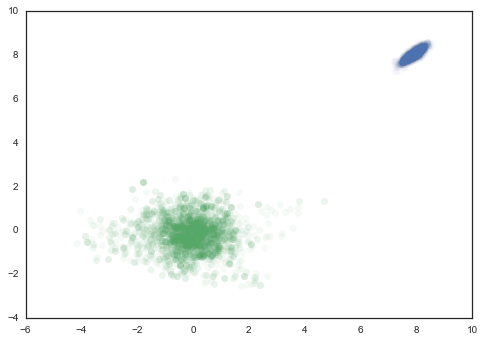

In [17]:
plt.plot(trace1[:,0], trace1[:,1], 'o', alpha=0.01, label='Mean 1 Posterior')
plt.plot(trace2[:,0], trace2[:,1], 'o', alpha=0.05, label='Mean 2 Posterior')